<a href="https://colab.research.google.com/github/gusti-amber/udemy_pytorch/blob/main/lecture/lec2_simple_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 手描き文字の読み込みと表示



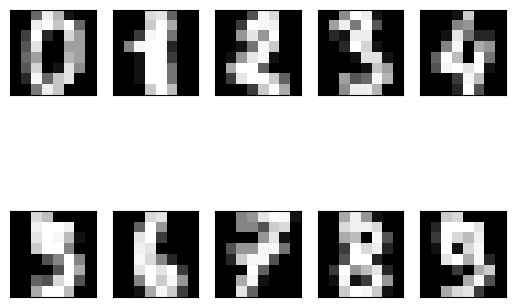

データの形状:  (1797, 64)
ラベル:  [0 1 2 3 4 5 6 7 8 9]


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

digits_data = datasets.load_digits()

n_img = 10 # 表示する文字画像の数
for i in range(n_img):
  ax = plt.subplot(2,5,i+1) # 2行5列でプロット, (i+1)番目に画像を配置
  plt.imshow(digits_data.data[i].reshape(8,8), cmap="Grays_r")
  ax.get_xaxis().set_visible(False) # x軸の非表示
  ax.get_yaxis().set_visible(False) # y軸の非表示
plt.show()

print("データの形状: ", digits_data.data.shape) # 文字画像は1797枚、8*8=64bit
print("ラベル: ", digits_data.target[:n_img])

# 2. データを訓練用とテスト用に分割

In [20]:
import torch
from sklearn.model_selection import train_test_split

digit_images = digits_data.data
labels = digits_data.target

# 訓練用の入力データ: x_train, 訓練用の正解データ: t_train, 訓練用は合計75%(デフォルト設定)
# テスト用の入力データ: x_test, テスト用の正解データ: t_test, テスト用は残り25%
x_train, x_test, t_train, t_test = train_test_split(digit_images, labels)

# 各データをTensorに変換
x_train = torch.tensor(x_train, dtype=torch.float32)
t_train = torch.tensor(t_train, dtype=torch.int64)

x_test = torch.tensor(x_test, dtype=torch.float32)
t_test = torch.tensor(t_test, dtype=torch.int64)


# 3. モデルの構築

In [21]:
from torch import nn

# NNの定義
# 入力は8*8=64bitの文字画像
# 出力は文字画像の0~9の分類
net = nn.Sequential(
    nn.Linear(64,32), # 全結合層
    nn.ReLU(),        # 活性化関数
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,10)
)

print(net)

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)


# 4. モデルの学習
損失関数: 交差エントロピー誤差

最適化アルゴリズム: SGD（確率的勾配降下法）

順伝播は訓練データ、テストデータ両方で行う

逆伝播は訓練データのみで行う

In [23]:
from torch import optim

# 損失関数の定義: 交差エントロピー誤差
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズムの定義: SGD（確率的勾配降下法）
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 損失ログ
record_loss_train = []
record_loss_test = []

# 学習(1000エポック)
for i in range(1000):
  # 勾配を0にする
  optimizer.zero_grad()

  # 順伝播
  y_train = net(x_train)
  y_test = net(x_test)

  # 誤差を求める
  loss_train = loss_fnc(y_train, t_train)
  loss_test = loss_fnc(y_test, t_test)
  record_loss_train.append(loss_train.item())
  record_loss_test.append(loss_test.item())

  # 逆伝播（勾配を求める）
  loss_train.backward()

  # パラメータ更新
  optimizer.step()

  # 100エポックごとに訓練用データとテスト用データ、それぞれの誤差を表示
  if i%100 == 0:
    print("Epock:", i, ", LossTrain:", loss_train.item(), ", LossTest: ", loss_test.item())


Epock: 0 , LossTrain: 2.4043471813201904 , LossTest:  2.411794424057007
Epock: 100 , LossTrain: 0.9776950478553772 , LossTest:  0.9797810912132263
Epock: 200 , LossTrain: 0.43845006823539734 , LossTest:  0.4473532736301422
Epock: 300 , LossTrain: 0.27249640226364136 , LossTest:  0.29135116934776306
Epock: 400 , LossTrain: 0.20156320929527283 , LossTest:  0.22807593643665314
Epock: 500 , LossTrain: 0.16184845566749573 , LossTest:  0.1940082460641861
Epock: 600 , LossTrain: 0.136291965842247 , LossTest:  0.17273306846618652
Epock: 700 , LossTrain: 0.11831488460302353 , LossTest:  0.15797916054725647
Epock: 800 , LossTrain: 0.10480421781539917 , LossTest:  0.14742496609687805
Epock: 900 , LossTrain: 0.0940602719783783 , LossTest:  0.13968364894390106


# 5. 誤差の推移
訓練データ、テストデータそれぞれの誤差の推移をプロットする

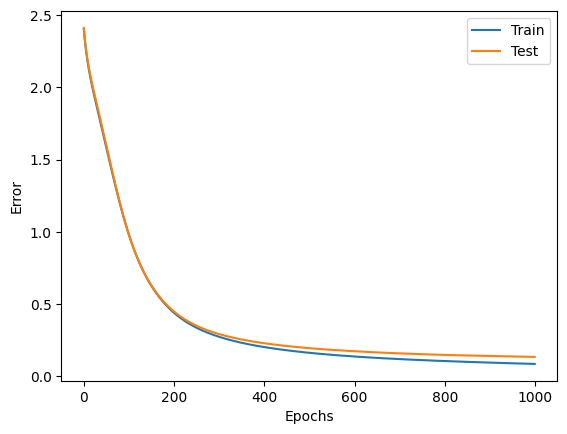

In [24]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend() # プロット時に指定したラベルを表示し、曲線の意味を表す

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# 6. 訓練済みモデルの性能評価
モデルの性能を測定するために、テストデータを使って正解率を測定する

In [26]:
y_test = net(x_test)

# テストデータの出力y_test（0~1の値を持つ確率で表される）の各行で最大値のインデックス、つまり文字画像の推測結果を返す
# 文字画像の推測結果が正解ラベルと一致すればカウントする。
cnt = (y_test.argmax(1) == t_test).sum().item()
print("正解率:", str(cnt/len(y_test)*100)+"%")

正解率: 96.44444444444444%


# 7. 訓練済みモデルによる予測

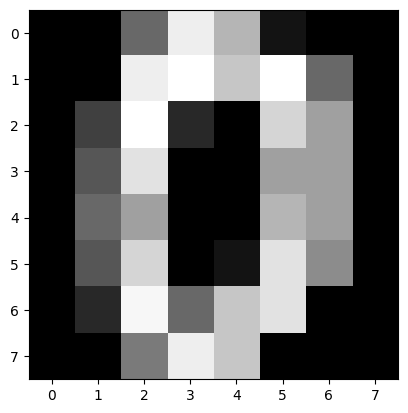

正解: 0 予測結果: 0


In [27]:
# 0の文字画像をデータセットから取り出してプロット
img_id = 0
x_pred = digit_images[img_id]
image = x_pred.reshape(8,8)
plt.imshow(image, cmap="Grays_r")
plt.show()

x_pred = torch.tensor(x_pred, dtype=torch.float32)
y_pred = net(x_pred)
print("正解:", labels[img_id], "予測結果:", y_pred.argmax().item())